# 1. Importing Dependencies

In [ ]:
!pip install tensorflow tensorflow.gpu matplotlib tenserflow.datasets ipywidgets

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus :
  tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [ ]:
data = tfds.load('fashion_mnist' , split = 'train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/60000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete4URTVB/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incomplete4URTVB/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
data.as_numpy_iterator().next()['label']

2

### 2.Building Dataset and Preprocessing

In [ ]:
import numpy as np

In [ ]:
dataiterator = data.as_numpy_iterator()

In [ ]:
dataiterator.next()

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

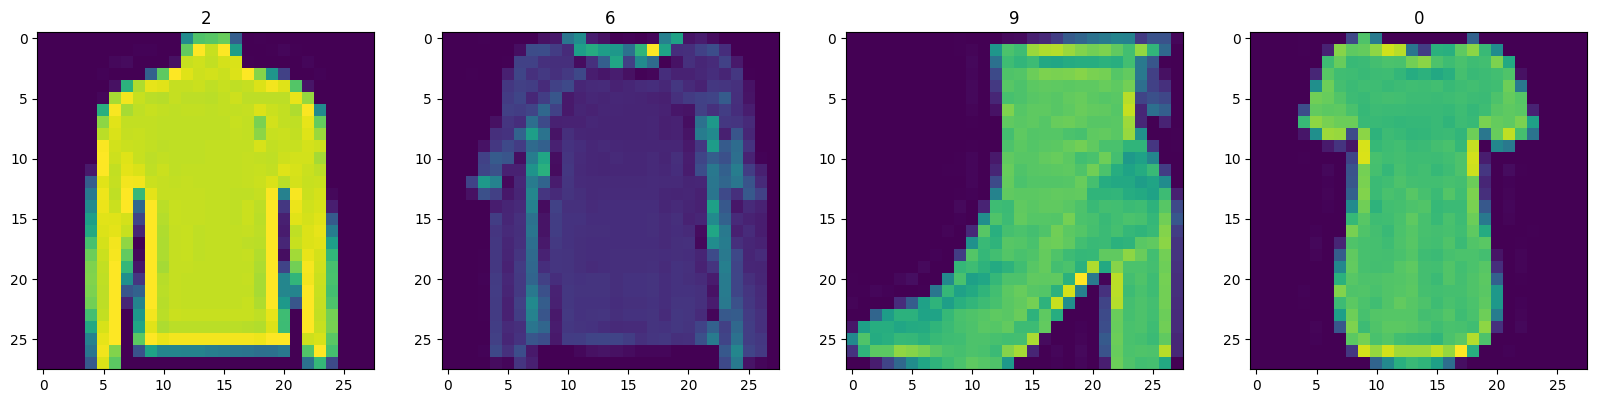

In [ ]:
# subplot formatting
fig ,ax = plt.subplots(ncols=4, figsize = (20,20))
for idx in range (4):
  batch = dataiterator.next()
  ax[idx].imshow(np.squeeze(batch['image']))
  ax[idx].title.set_text(batch['label'])



In [ ]:
#scale and return images only
def scale_images(data) :
  image = data['image']
  return image/255

In [ ]:
#Reload the dataset
data = tfds.load('fashion_mnist' , split = 'train')
#Running the dataset for that batch
data = data.map(scale_images)
#cache the dataset for that batch
data = data.cache()
##shuffling
data = data.shuffle(60000)
# batch into 128 images per sample
data = data.batch(128)
#Reducing Likelihood
data = data.prefetch(64)

In [ ]:
data.as_numpy_iterator().next().shape

(128, 28, 28, 1)

## 3.Build Neural Network

**3.1 import Modeling Components**

In [ ]:
#Bring in the sequential API for the generator and Discriminator
from tensorflow.keras.models import Sequential
#Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D , Dense , Flatten ,Reshape, LeakyReLU, Dropout ,UpSampling2D

**3.2 Build Generator**

In [ ]:
def build_generator():
  model = Sequential()

  # Reshapping
  # Beginnings of a generated image
  model.add(Dense(7*7*128 , input_dim=128))
  model.add(LeakyReLU(0.2))
  model.add(Reshape((7,7,128)))

  # Upsampling block 1
  model.add(UpSampling2D())
  model.add(Conv2D(128, 5,padding='same'))
  model.add(LeakyReLU(0.2))

  # Upsampling block 2
  model.add(UpSampling2D())
  model.add(Conv2D(128, 5,padding='same'))
  model.add(LeakyReLU(0.2))

  # Conv block 1
  model.add(Conv2D(128, 4,padding='same'))
  model.add(LeakyReLU(0.2))

  # Conv block 2
  model.add(Conv2D(128, 4,padding='same'))
  model.add(LeakyReLU(0.2))

  #Convolutional Layer
  model.add(Conv2D(1,4,padding='same' , activation = 'sigmoid'))

  return model

In [ ]:
generator = build_generator()

In [ ]:
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              809088    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 14, 14, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                        

1/1 [==============================] - 0s 18ms/step


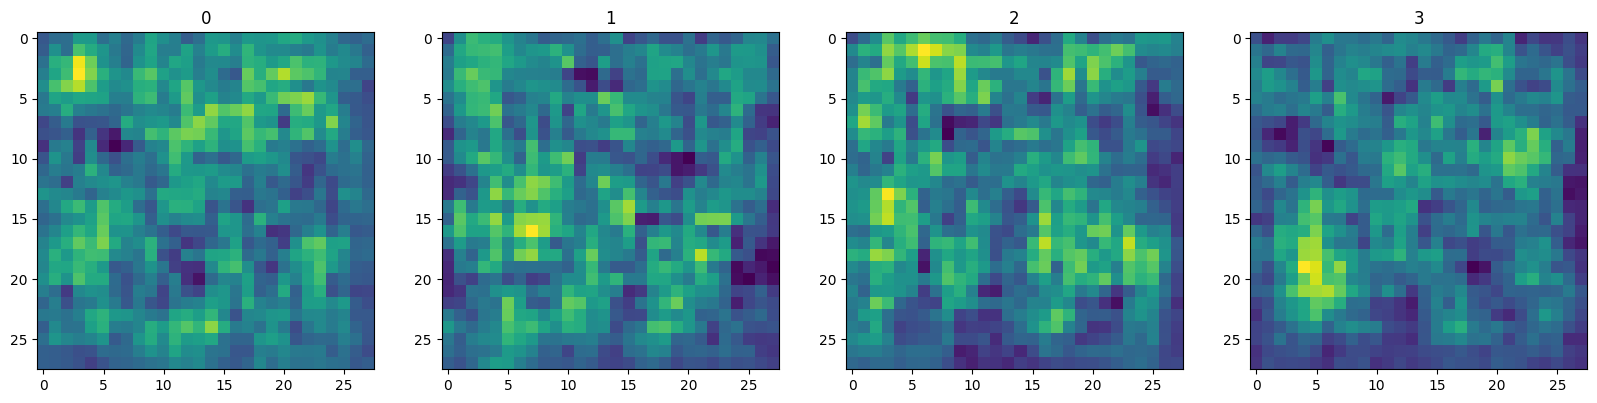

In [ ]:
# Generate New Fashion
img = generator.predict(np.random.randn(4,128,1))
fig ,ax = plt.subplots(ncols=4, figsize = (20,20))
for idx, img in enumerate(img):
  ax[idx].imshow(np.squeeze(img))
  ax[idx].title.set_text(idx)


**3.3 Building Discriminator**

In [ ]:
from tensorflow.python.ops.gen_nn_ops import LeakyRelu
def build_discriminator():
  model = Sequential()

  # First Conv Block
  model.add(Conv2D(32, 5, input_shape = (28,28,1)))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # second  Conv Block
  model.add(Conv2D(64 , 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Third  Conv Block
  model.add(Conv2D(128 , 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

   # Fourth  Conv Block
  model.add(Conv2D(256 , 5))
  model.add(LeakyReLU(0.2))
  model.add(Dropout(0.4))

  # Flatten then pass to dense layer
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1,activation='sigmoid'))

  return model

In [ ]:
discriminator = build_discriminator()

In [ ]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 24, 24, 32)        0         
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 20, 20, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 128)      

In [ ]:
img = generator.predict(np.random.randn(4,128,1))

1/1 [==============================] - 0s 17ms/step


In [ ]:
img = img[0]

In [ ]:
img.shape

(4, 28, 28, 1)

In [ ]:
discriminator.predict(img)

1/1 [==============================] - 0s 230ms/step


array([[0.5073516 ],
       [0.5068799 ],
       [0.50725293],
       [0.5071347 ]], dtype=float32)

# 4. Construst Training Loop

**4.1 Setup Losses and Optimizers**

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [ ]:
# Setting OPtimizers and Losses
g_opt = Adam(learning_rate=0.0001)
d_opt = Adam(learning_rate=0.00001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

**4.2 Build Subclassed Model**

In [ ]:
# Importing the base model class to subclass our training step
from tensorflow.keras.models import Model

In [ ]:
tf.concat([tf.zeros_like(tf.random.normal((6,128))) , tf.ones_like(tf.random.normal((6,128)))] , axis = 0)

<tf.Tensor: shape=(12, 128), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)>

In [ ]:
class FashionGAN(Model):
  def __init__(self, generator , discriminator , *args  , **kwargs) :
    # Pass through args and kwargs to base class
    super().__init__(*args, **kwargs)

    # Create attributes for gen and disc
    self.generator = generator
    self.discriminator = discriminator

  def compile(self , g_opt , d_opt , g_loss , d_loss , *args , **kwargs) :
    # Compile with base class
    super().compile(*args , **kwargs)

    # Create attributes for losses and optimizers
    self.g_opt = g_opt
    self.d_opt = d_opt
    self.g_loss = g_loss
    self.d_loss = d_loss


  def train_step(self, batch):
    real_images = batch
    fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)

    # Train the discriminator
    with tf.GradientTape() as d_tape :
      yhat_real = self.discriminator (real_images , training = True)
      yhat_fake = self.discriminator(fake_images , training = True)
      yhat_realfake = tf.concat([yhat_real , yhat_fake] , axis = 0)

      # Create labels for real and fake images
      y_realfake = tf.concat([tf.zeros_like(yhat_real) , tf.ones_like(yhat_fake)] , axis =0)

      # Add some noise to the outputs
      noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
      noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
      y_realfake += tf.concat([noise_real , noise_fake] , axis = 0)

      # Calculate loss
      total_d_loss = self.d_loss(y_realfake , yhat_realfake)

       # Apply backpropagation for the discriminator
      dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
      self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

    with tf.GradientTape() as g_tape :
         # Generate some new images
        gen_images = self.generator(tf.random.normal((128, 128, 1)), training=True)

        # Calculate the predicted labels
        predicted_labels = self.discriminator(gen_images , training = False )

        # Calculate loss
        total_g_loss = self.g_loss(tf.zeros_like(predicted_labels) , predicted_labels)

       # Apply backpropagation for the generator
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))



    return {"d_loss ":total_d_loss, "g_loss":total_g_loss }

In [ ]:
# Create an instance of the model
fashgan = FashionGAN(generator , discriminator)

In [ ]:
# Compile the model
fashgan.compile(g_opt , d_opt , g_loss , d_loss)

### 4.3 Build Callback

In [ ]:
import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback

In [ ]:
class ModelMonitor (Callback) :
  def __init__(self, num_img = 3 , latent_dim=128 ):
    self.num_img = num_img
    self.latent_dim = latent_dim

  def on_epoch_end(self , epoch , logs = None) :
    random_latent_vectors = tf.random.uniform((self.num_img , self.latent_dim , 1))
    generated_images = self.model.generator(random_latent_vectors)
    generated_images *= 255
    generated_images.numpy()
    for i in range(self.num_img):
      img = array_to_img(generated_images[i])
      img.save(os.path.join('images ', f'generated_img_{epoch}_{i}.png'))


### **4.3 Train**

In [ ]:
hist = fashgan.fit(data , epochs = 20 , callbacks = [ModelMonitor()] )

Epoch 1/20
469/469 [==============================] - 89s 165ms/step - d_loss : 0.4954 - g_loss: 2.1185
Epoch 2/20
469/469 [==============================] - 77s 164ms/step - d_loss : 0.3459 - g_loss: 1.9135
Epoch 3/20
469/469 [==============================] - 77s 163ms/step - d_loss : 0.2770 - g_loss: 2.6577
Epoch 4/20
469/469 [==============================] - 76s 162ms/step - d_loss : 0.6394 - g_loss: 0.9112
Epoch 5/20
469/469 [==============================] - 77s 164ms/step - d_loss : 0.5439 - g_loss: 0.4588
Epoch 6/20
469/469 [==============================] - 77s 164ms/step - d_loss : 0.4161 - g_loss: 0.1274
Epoch 7/20
469/469 [==============================] - 77s 165ms/step - d_loss : 0.4015 - g_loss: 0.0313
Epoch 8/20
469/469 [==============================] - 77s 164ms/step - d_loss : 0.7273 - g_loss: 0.4948
Epoch 9/20
469/469 [==============================] - 76s 163ms/step - d_loss : 0.6975 - g_loss: 0.5949
Epoch 10/20
469/469 [==============================] - 77s 164ms

### 4.4 Review Performance

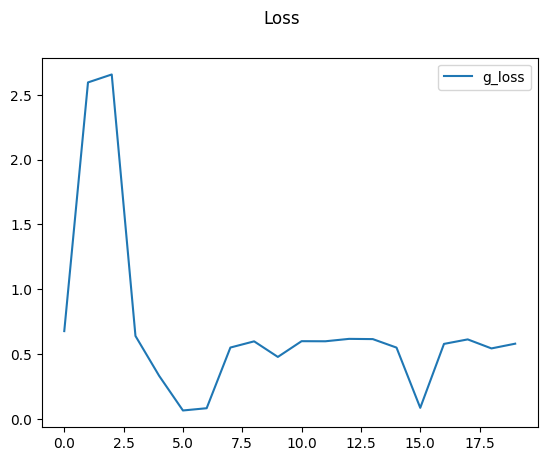

In [ ]:
plt.suptitle('Loss')

if 'd_loss' in hist.history:
    plt.plot(hist.history['d_loss'], label='d_loss')

if 'g_loss' in hist.history:
    plt.plot(hist.history['g_loss'], label='g_loss')

plt.legend()
plt.show()


# 5. Test out Generator

In [ ]:
generator.load_weights(os.path.join('sample_data','generatormodel.h5'))

In [ ]:
imgs = generator.predict(tf.random.normal((16, 128 , 1)))

1/1 [==============================] - 0s 478ms/step


In [ ]:
fig , ax = plt.subplots(ncols=4 , nrows = 4 , figsize =(20,20))
for r in range(4):
  for c in range(4):
    ax[r][c].imshow(imgs[(r+1)*(c+1)-1])

### 5.2 Save the Model

In [ ]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
